In [55]:
from asynch import *
import tensorflow as tf
from utils import create_session_config
from models.utils import corr
import numpy as np
import tensorflow_probability as tp
FLAGS.per_process_gpu_memory_fraction=0.15
from data.registry import etf2d
from models.nn_pdf_common import transform_x, create_cdf_layer_partial_monotonic_MLP, create_pdf_layer_mv
from models.nn_pdf_common import create_partially_monotone_dense_layer,create_monotone_dense_layer,create_positive_weights
from models.utils import extract_xy, metric_loglikelihood, train_op, constrain_cdf, print_tensor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
# np.set_printoptions(threshold=np.nan)

In [38]:
data_loader = etf2d()

loaded data: Yahoo_symbols_SPY_DIA_start_2011-01-03_end_2015-04-14.npz


In [61]:
def cdf_transform(x, y, params, positive_transform,final_activation=None, print_prefix=""):
    x_transform = transform_x(params, x)

    y1 = tf.slice(y, [0, 0], [-1, 1])
    y2 = tf.slice(y, [0, 1], [-1, 1])

    xy1 = tf.concat([x_transform, y1], axis=1)
    xy2 = tf.concat([x_transform, y2], axis=1)

    layer_size2 = params["layer_size2"]

    activation = tf.nn.relu

    with tf.variable_scope("cdf_transform"):
        with tf.variable_scope("xy1_partially_monotone"):
            xy1 = create_partially_monotone_dense_layer(xy1, layer_size2, x_transform.shape[-1].value,
                                                        1, activation=activation, positive_transform=positive_transform)
        with tf.variable_scope("xy1_l1"):
            xy1 = create_monotone_dense_layer(xy1, layer_size2, activation=activation, positive_transform=positive_transform)

        with tf.variable_scope("xy2_partially_monotone"):
            xy2 = create_partially_monotone_dense_layer(xy2, layer_size2, x_transform.shape[-1].value,
                                                        1, activation=activation, positive_transform=positive_transform)

        with tf.variable_scope("xy2_l1"):
            xy2 = create_monotone_dense_layer(xy2, layer_size2, activation=activation, positive_transform=positive_transform)

        with tf.variable_scope("xy_prefinal"):
            # xy_prefinal = tf.multiply(tf.nn.softmax(xy1), tf.nn.softmax(xy2))
            xy_prefinal = tf.multiply(xy1, xy2)
#             xy_prefinal = create_monotone_dense_layer(tf.concat([xy1,xy2], axis=1), layer_size2, activation=activation,
#                                                       positive_transform=positive_transform)

        return create_monotone_dense_layer(xy_prefinal, 1, activation=final_activation,
                                           positive_transform=positive_transform)
       
    

def create_pdf_layer(cdf, y):
    with tf.name_scope("pdf_layer"):
        assert cdf.shape[0].value == y.shape[0].value
        assert y.shape[-1].value == 1
        assert cdf.shape[-1].value == 1
        # because it is list and cdf is only 1 element
        return tf.gradients(cdf, y)[0]
    
def create_pdf_layer_mv(cdf, y_components):
    gradients = cdf
    for i, y in enumerate(y_components):
        with tf.name_scope("pdf_layer_mv_%d"%i):
            gradients = create_pdf_layer(gradients, y)
#             break
    return gradients

def normalized_cdf_transform(x, y, params, positive_transform, mode):
    y_max_values_vars = tf.get_variable("y_max_values_var", trainable=False, dtype=tf.float32,
                                        shape=(1, y.shape[-1].value))
    if mode == tf.estimator.ModeKeys.TRAIN:
        y_max_values = tf.reshape(tf.reduce_max(y, axis=0), [1, y.shape[-1].value])
        y_max_values_vars = print_tensor(tf.assign(y_max_values_vars, y_max_values, name="y_max"))

    with tf.variable_scope("cdf_normalization",reuse=tf.AUTO_REUSE):
        non_normalized_cdf = print_tensor(cdf_transform(x, y, params, positive_transform, print_prefix="non_normalized_",final_activation=tf.nn.relu), name="cdf_nominator")
        cdf_normalization = print_tensor(cdf_transform(x, tf.tile(y_max_values_vars, [tf.shape(x)[0], 1]),
                                                                  params, positive_transform, print_prefix="normalization_",final_activation=tf.nn.relu), name="cdf_denominator")
    # return print_tensor(constrain_cdf(tf.div(non_normalized_cdf, cdf_normalization)), name="cdf")
    return print_tensor(tf.div(non_normalized_cdf, cdf_normalization),name="cdf")

def normalized_cdf_transform2(x, y, params, positive_transform, mode):
    return cdf_transform(x, y, params, positive_transform, final_activation=tf.nn.sigmoid)

def run(x_data,y_data):
    params = {"y_size": 2, "positive_transform": "square", "x_size": 2, "batch_size": 686, "arch1": [55, 55, 55], 
              "tensorboard_folder": "tensorboard", "learning_rate": 0.00018040513535031992, "num_layers2": 5, 
              "arch2": [187, 187, 187, 187, 187], "tf_random_seed": 3322132469, "num_layers1": 3, "layer_size1": 55, 
               "layer_size2": 187}
    mode = tf.estimator.ModeKeys.TRAIN
    tf.set_random_seed(params["tf_random_seed"])
    
    x=tf.placeholder(shape=(None,2),dtype=tf.float32)
    y=tf.placeholder(shape=(None,2),dtype=tf.float32)
    
    positive_transform = params['positive_transform']
    learning_rate = params["learning_rate"]
    x_size, y_size = params["x_size"],params["y_size"]
    
    y_components = [tf.slice(y, [0,i],[-1,1]) for i in range(y_size)]
    y_components_combined = tf.concat(y_components, axis=1)
    
    with tf.variable_scope("cdf",reuse=tf.AUTO_REUSE):
        norm_fun=normalized_cdf_transform
        cdf = norm_fun(x, y_components_combined, params, positive_transform, mode)
    
        delta=1e-2
        
        def pdf1(comp2):
            return (norm_fun(x, tf.concat([y_components[0]+delta,comp2], axis=1), params, positive_transform, mode) -
        norm_fun(x, tf.concat([y_components[0]-delta,comp2], axis=1), params, positive_transform, mode))/(2*delta)
        
        pdf_num = (pdf1(y_components[1]+delta) - pdf1(y_components[1]-delta))/(2*delta)
   
    pdf = create_pdf_layer_mv(cdf, y_components)
    
    with tf.Session(config=create_session_config()) as sess:
        sess.run(tf.global_variables_initializer())
        return sess.run([cdf,pdf,pdf_num], feed_dict={x:x_data,y:y_data})

def invoke_for_mesh(centre_y,x,  delta, points, fun):
    y_centre_1 = centre_y[0]
    y_centre_2 = centre_y[1]
    
    y_1 = np.linspace(y_centre_1-delta,y_centre_1+delta,points)
    y_2 = np.linspace(y_centre_2-delta,y_centre_2+delta,points)
    
    y_grid = np.meshgrid(y_1,y_2)

    y_grid_flat = np.concatenate(list(map(lambda a: a.reshape(-1,1), y_grid)), axis=1)
    
    res = invoke_in_process_pool(1, Callable(run, x_data=np.tile(x, [points*points,1]) , 
                                         y_data=y_grid_flat))[0]
    

    return fun(y_grid, y_grid_flat, res),res


# res_centre = invoke_in_process_pool(1, Callable(run, x_data=data_loader.train_x[np.newaxis, y_point,:] , 
#                                          y_data=data_loader.train_y[np.newaxis,y_point,:]))[0]

Text(0.5,0,'y1')

Text(0.5,0,'y2')

Text(0.5,0,'cdf')

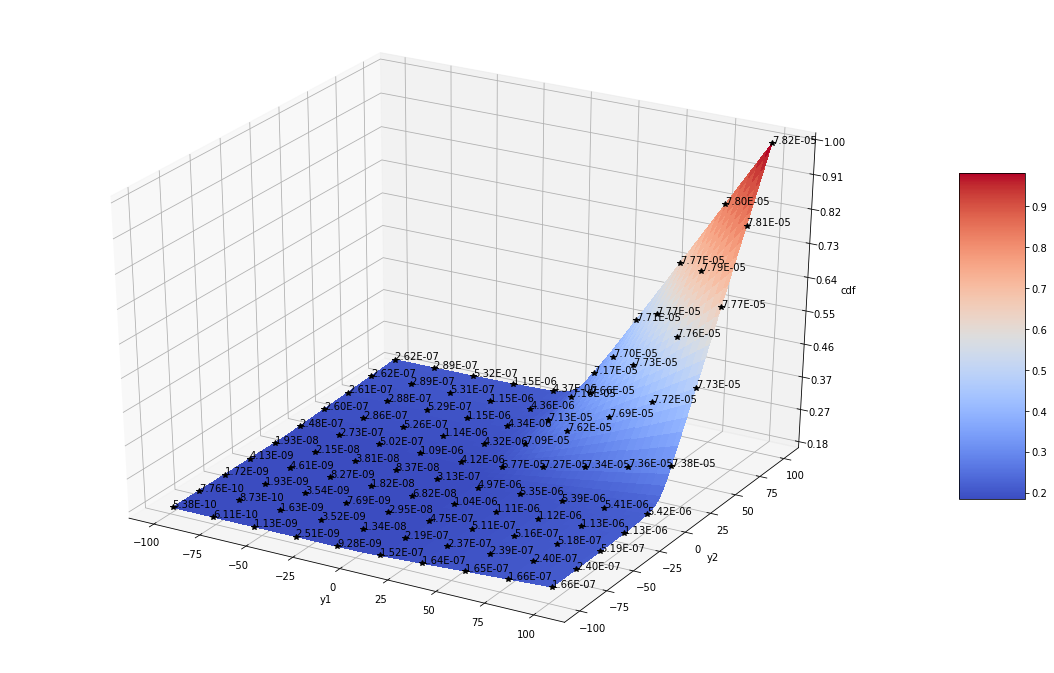

In [62]:
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')
ax.set_xlabel("y1");
ax.set_ylabel("y2");
ax.set_zlabel("cdf");

delta=100.0
centre_idx=0
surf,res = invoke_for_mesh(data_loader.train_y[centre_idx,:], data_loader.train_x[centre_idx,:],delta=delta,points=100, 
                       fun=lambda y_grid, y_grid_flat, res: ax.plot_surface(y_grid[0],y_grid[1],res[0].reshape(100,100),cmap=cm.coolwarm, linewidth=0, antialiased=False))

_,_=invoke_for_mesh(data_loader.train_y[centre_idx,:], data_loader.train_x[centre_idx,:],delta=delta,points=10,
                fun=lambda y_grid, y_grid_flat, res: ax.plot(y_grid[0].flatten(), y_grid[1].flatten(), res[0].flatten(), "*",color="black"))

def print_vals(y_grid, y_grid_flat, res):
    for y1,y2,cdf,pdf in zip(y_grid[0].flatten(),y_grid[1].flatten(), res[0].flatten(), res[1].flatten()):
        ax.text(y1, y2, cdf, '%.2E'%pdf, color='black' if pdf >= 0 else "red")

_,_=invoke_for_mesh(data_loader.train_y[centre_idx,:], data_loader.train_x[centre_idx,:],delta=delta,points=10,fun= print_vals)

# Customize the z axis.
# ax.set_zlim(0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.view_init(10, 180)

plt.show()


In [36]:
np.all(res[1]>0)
np.set_printoptions(threshold=10)
np.c_[res[1],res[2]]

True

array([[ 4.1960949e-12,  0.0000000e+00],
       [ 4.6651888e-12,  0.0000000e+00],
       [ 5.1936671e-12,  0.0000000e+00],
       ...,
       [ 9.7962402e-11,  0.0000000e+00],
       [ 8.9744656e-11, -1.4901161e-04],
       [ 8.2181664e-11, -1.4901161e-04]], dtype=float32)

In [116]:
y_centre_1
y_centre_2
res_centre

0.99077225

0.8280252

array([[ 1.0000000e+00, -2.4043573e-05]], dtype=float32)

In [117]:
y_grid_flat

array([[-19.00922775, -19.17197478],
       [-18.19290122, -19.17197478],
       [-17.37657469, -19.17197478],
       ...,
       [ 19.35811919,  20.82802522],
       [ 20.17444572,  20.82802522],
       [ 20.99077225,  20.82802522]])

In [131]:
res[:,0].reshape(points,points)

array([[0.0494892 , 0.05248304, 0.05563565, ..., 0.5205302 , 0.53551227,
        0.5502098 ],
       [0.05229415, 0.05538378, 0.058638  , ..., 0.5346875 , 0.54963666,
        0.56427145],
       [0.05524927, 0.05844036, 0.06180247, ..., 0.5490528 , 0.56393874,
        0.57848126],
       ...,
       [0.4852726 , 0.5000317 , 0.515087  , ..., 0.9882231 , 0.99146134,
        0.994536  ],
       [0.49958614, 0.5143923 , 0.529463  , ..., 0.9912249 , 0.9943612 ,
        0.99733984],
       [0.5137107 , 0.5285332 , 0.54358846, ..., 0.9940721 , 0.99711215,
        1.        ]], dtype=float32)